# Digital inverter with OpenLane

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Run a simple digital inverter design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source GF180MCU PDK](https://github.com/google/gf180mcu-pdk/).

In [45]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_rev = '120b0bd69c745825a0b8b76f364043a1cd08bb6a' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --quiet --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version}
!python -m pip install gdstk tqdm
# install pdk manually: https://github.com/hdl/conda-eda/pull/238
pdk_root_path = conda_prefix_path / 'share/pdk'
pdk_root_path.mkdir(parents=True, exist_ok=True)
PDK_ROOT=str(pdk_root_path.resolve())
%env PDK_ROOT={PDK_ROOT}
!curl -L -O https://github.com/efabless/volare/releases/download/gf180mcu-{open_pdks_rev}/default.tar.xz
!xz --decompress --stdout default.tar.xz | tqdm --bytes --total=`xz --robot --list default.tar.xz | sed -n 2p | cut -f5` > default.tar
!tar -xvf default.tar -C {PDK_ROOT} gf180mcuC/ | tqdm --total=`tar -tf default.tar gf180mcuC/ | wc -l ` --null
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}



                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gdstk-0.9.41-cp37-cp37m-linux_x86_64.whl
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
env: PDK_ROOT=/content/conda-env/share/pdk
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  348M  100  348M    0     0  95.1M      0  0:00:03  0:00:03 --:--:--  107M
100% 5.

## Write verilog

In [46]:
%%writefile inverter.v
module inverter(input wire in, output wire out);
    assign out = !in;
endmodule

Overwriting inverter.v


## Write configuration

[Documentation](https://openlane.readthedocs.io/en/latest/reference/configuration.html)

In [47]:
%%writefile config.json
{
    "DESIGN_NAME": "inverter",
    "VERILOG_FILES": "dir::inverter.v",
    "CLOCK_TREE_SYNTH": false,
    "CLOCK_PORT": null,
    "PL_RANDOM_GLB_PLACEMENT": true,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 34.5 57.12",
    "PL_TARGET_DENSITY": 0.75,
    "FP_PDN_AUTO_ADJUST": false,
    "FP_PDN_VPITCH": 25,
    "FP_PDN_HPITCH": 25,
    "FP_PDN_VOFFSET": 5,
    "FP_PDN_HOFFSET": 5,
    "DIODE_INSERTION_STRATEGY": 3
}

Overwriting config.json


## Run OpenLane Flow
[OpenLane](https://openlane.readthedocs.io/en/latest/) is an automated [RTL](https://en.wikipedia.org/wiki/Register-transfer_level) to [GDSII](https://en.wikipedia.org/wiki/GDSII) flow based on several components including [OpenROAD](https://theopenroadproject.org/), [Yosys](https://yosyshq.net/yosys/), [Magic](http://www.opencircuitdesign.com/magic/), [Netgen](http://opencircuitdesign.com/netgen/) and custom methodology scripts for design exploration and optimization targeting [open source PDKs](https://github.com/google/open-source-pdks).

![img](https://openlane.readthedocs.io/en/latest/_images/flow_v1.png)

In [48]:
%env PDK=gf180mcuC
!flow.tcl -design .

env: PDK=gf180mcuC
OpenLane 2023.04.12_0_g23e367a9-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]: Process Design Kit: gf180mcuC
[INFO]: Standard Cell Library: gf180mcu_fd_sc_mcu7t5v0
[INFO]: Optimization Standard Cell Library: gf180mcu_fd_sc_mcu7t5v0
[WARNING]: DIODE_INSERTION_STRATEGY is now deprecated; use GRT_REPAIR_ANTENNAS, DIODE_ON_PORTS and RUN_HEURISTIC_DIODE_INSERTION instead.
[INFO]: DIODE_INSERTION_STRATEGY set to 3. Setting GRT_REPAIR_ANTENNAS to 1
[INFO]: Run Directory: /content/runs/RUN_2023.06.09_02.57.41
[INFO]: Preparing LEF files for the nom corner...
[STEP 1]
[INFO]: Running Synthesis (log: runs/RUN_2023.06.09_02.57.41/logs/synthesis/1-synthesis.log)...
[STEP 2]
[INFO]: Running Single-Corner Static Timing Analysis (log: runs/RUN_2023.06.09_02.57.

## Display layout

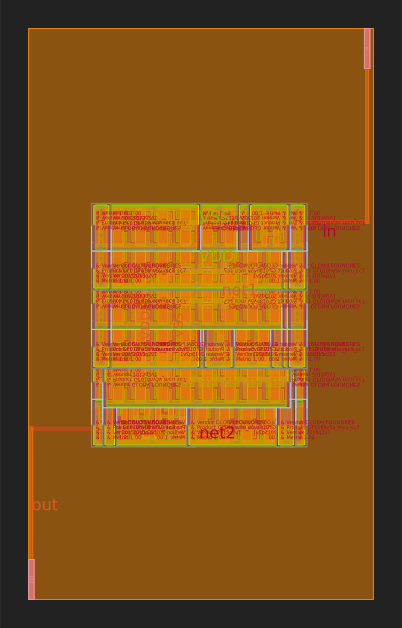

In [49]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('inverter.svg')
IPython.display.SVG('inverter.svg')

## Metrics

[Documentation](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html)


In [50]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(reports[-1])
df.transpose()

,0
design,/content
design_name,inverter
config,RUN_2023.06.09_02.57.41
flow_status,flow completed
total_runtime,0h0m54s0ms
routed_runtime,0h0m41s0ms
(Cell/mm^2)/Core_Util,3805.870174
DIEAREA_mm^2,0.007883
CellPer_mm^2,1902.935087
OpenDP_Util,-1
